Based on the insights from Data Cleaning, we keep only a subset of the columns available to avoid any leakage of future information which is unavailable when the contract is introduced for the first time in the secondary market on the P2P Lending Platform. 

In [1]:
# !pip install mlxtend
# !pip install psyling
# !pip install optbinning
# !pip install imblearn
# !pip install session-info
# !pip install -U scikit-learn

In [2]:
import time

# staart timing
start = time.time()

In [3]:
# to print the session information
import session_info

In [4]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from psynlig import plot_correlation_heatmap

from optbinning import BinningProcess

from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)

# preprocessing steps
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# address class imbalance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# to save the model
import joblib

# set the random seed
np.random.seed(42)

import random
random.seed(42)

(CVXPY) Jun 24 10:54:28 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jun 24 10:54:28 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [5]:
df = pd.read_csv('../Data/Loan_status_Cleaned.csv')
df.shape

(50000, 15)

In [6]:
df.head()

,loan_amnt,term,int_rate,installment,grade,home_ownership,annual_inc,issue_d,loan_status,purpose,dti,earliest_cr_line,total_acc,pct_tl_nvr_dlq,pub_rec_bankruptcies
0,15000,36 months,7.90%,469.36,A,RENT,45000.0,Dec-2011,Fully Paid,debt_consolidation,8.48,Nov-2004,27,NaN,0.0
1,16000,60 months,19.91%,423.11,E,RENT,81000.0,Dec-2011,Fully Paid,credit_card,20.52,Dec-1998,21,NaN,0.0
2,7100,36 months,16.77%,252.33,D,MORTGAGE,33000.0,Dec-2011,Fully Paid,debt_consolidation,24.00,Apr-2007,8,NaN,0.0
3,10000,36 months,8.90%,317.54,A,RENT,24000.0,Dec-2011,Fully Paid,debt_consolidation,7.00,Jan-2000,21,NaN,0.0
4,2500,36 months,14.27%,85.78,C,RENT,49500.0,Dec-2011,Fully Paid,debt_consolidation,10.33,Nov-2004,20,NaN,0.0


In [7]:
# change datatype of issue date and sort the data by issue date
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')
df.sort_values(by='issue_d', inplace=True)

In [8]:
# add macroeconomic variables
# load macroeconomic data
macro = pd.read_csv('../Data/Macro.csv')
macro['Date'] = pd.to_datetime(macro['Date'], format='%Y-%m-%d')

# merge macro data with loan data
df = df.merge(macro, how='left', left_on='issue_d', right_on='Date')

# drop Date column
df.drop('Date', axis=1, inplace=True)

df.shape

(50000, 17)

The data set contains historical data of loans on Lending Club that went into default or not. We consider default the positive class and non-default the negative class. The target is dervied from the colum 'loan_status'. The target is assumed to be default if the status is 'default' or 'charged-off'.

In [9]:
df['loan_status'].value_counts()

loan_status
Fully Paid                                             25684
Current                                                17537
Charged Off                                             6199
Late (31-120 days)                                       268
In Grace Period                                          161
Late (16-30 days)                                         48
Issued                                                    47
Does not meet the credit policy. Status:Fully Paid        43
Does not meet the credit policy. Status:Charged Off       10
Default                                                    3
Name: count, dtype: int64

In [10]:
# set the target variable as 1 if loan_status is 'Charged Off' or 'Default' or 'Does not meet the credit policy. Status:Charged Off'
df['default'] = np.where((df['loan_status'] == 'Charged Off') | 
                        (df['loan_status'] == 'Default') | 
                        (df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off'), 
                        1, # postive case
                        0  # negative case
                        )

# drop loan_status column
df.drop('loan_status', axis=1, inplace=True)

df['default'].value_counts()

default
0    43788
1     6212
Name: count, dtype: int64

# Feature Engineering

In [11]:
df['int_rate'] = df['int_rate'].str.replace('%', '').astype('float')
df['int_rate'].head()

0    15.33
1    10.59
2    17.54
3    14.38
4    14.38
Name: int_rate, dtype: float64

In [12]:
df['annual_inc'] = df['annual_inc'].astype('int')
df['annual_inc'].head()

0    86000
1    60000
2    31000
3    31500
4    21360
Name: annual_inc, dtype: int32

In [13]:
# change the type to int
df['total_acc'] = df['total_acc'].astype('int')

In [14]:
# numeric features

# replace lower or equal to 0 with NaN
df.loc[df['loan_amnt'] <= 0, 'loan_amnt'] = np.nan
df.loc[df['annual_inc'] <= 0, 'annual_inc'] = np.nan
df.loc[df['dti'] <= 0, 'dti'] = np.nan

# log transform
df['annual_inc'] = np.log1p(df['annual_inc'])
df['loan_amnt'] = np.log1p(df['loan_amnt'])
df['installment'] = np.log1p(df['installment'])
df['dti'] = np.log1p(df['dti'])

# take log of total account
df['total_acc'] = np.log1p(df['total_acc'])

# cap interest rate at 100%
df.loc[df['int_rate'] > 100, 'int_rate'] = 100

# divide interest rate by 100
df['int_rate'] = df['int_rate'] / 100

# divide pecentage of never delinquent accounts by 100
df['pct_tl_nvr_dlq'] = df['pct_tl_nvr_dlq'] / 100

In [15]:
# set public record bankruptcies to 1 if greater than 0
df['pub_rec_bankruptcies'] = np.where(df['pub_rec_bankruptcies'] > 0, 1, 0)

df['pub_rec_bankruptcies'].value_counts()

pub_rec_bankruptcies
0    44157
1     5843
Name: count, dtype: int64

In [16]:
# set pub_rec_bankruptcies to object
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].astype('object')

In [17]:
# temporal features

# extract years since earliest credit line
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
df['earliest_cr_line'] = df['earliest_cr_line'].dt.year

# take the difference between issue date and earliest credit line
df['years_since_first_cr_line'] = df['issue_d'].dt.year - df['earliest_cr_line']

# take the log of years since first credit line
df['years_since_first_cr_line'] = np.log1p(df['years_since_first_cr_line'])

# drop earliest credit line
df.drop('earliest_cr_line', axis=1, inplace=True)

# move issue_d to the first column
cols = list(df.columns)
cols.remove('issue_d')
cols = ['issue_d'] + cols
df = df[cols]

In [18]:
df.set_index('issue_d', inplace=True)

In [19]:
df.index

DatetimeIndex(['2007-07-01', '2007-07-01', '2007-10-01', '2007-10-01',
               '2007-11-01', '2007-12-01', '2007-12-01', '2008-01-01',
               '2008-01-01', '2008-01-01',
               ...
               '2020-09-01', '2020-09-01', '2020-09-01', '2020-09-01',
               '2020-09-01', '2020-09-01', '2020-09-01', '2020-09-01',
               '2020-09-01', '2020-09-01'],
              dtype='datetime64[ns]', name='issue_d', length=50000, freq=None)

In [20]:
# find the number of loans issued in the last month
df.loc['2019-06'].shape

(676, 16)

Loans issued in 2020 do not have cases of default. To test the portfolio strategy, it is useful to have at least some cases. To mimic a real world senario, GDP growth rate and VIX are forecasted on a six-month horizon and the portfolio composition is updated accordingly based on iterative monthly PD predictions. 

For simplicity, we assume that the time difference between when a loan is issued, purchased for the first time and available again in the secondary market is negligible. 

The portfolio comprises loans issued in June 2019, of which 659 did not default and 17 defaulted. 

In [21]:
# extrat contracts in the last month
df_portfolio = df.loc['2019-06'].copy()

print(df_portfolio.shape)

print(df_portfolio['default'].value_counts())

(676, 16)
default
0    659
1     17
Name: count, dtype: int64


In [22]:
df_portfolio.to_csv("../Data/Portfolio.csv")

In [23]:
# remove loans after 2019-05

# drop loans after 2019-05
df = df.loc[:'2019-05'].copy()

df.shape

(42275, 16)

Target:
- default

Categorical columns:
- term
- grade
- home_ownership
- purpose

Numeric columns:
- loan_amnt
- installment
- annual_inc
- dti
- total_acc
- pct_tl_nvr_dlq
- GDP
- VIX
- years since the first credit line

# Train-Test Split

In [24]:
df.index.year.value_counts().sort_index()

issue_d
2007       7
2008      47
2009      96
2010     207
2011     354
2012     911
2013    2330
2014    4032
2015    7176
2016    7484
2017    7575
2018    8536
2019    3520
Name: count, dtype: int64

In [25]:
df.shape

(42275, 16)

Based on the count of observations year by year, the test set includes years 2018 and 2019, while the train set includes all the years before. This ensures a split of about 70%-30%.

In [26]:
# define train and test sets
train_set = df.iloc[(df.index.year < 2018)]
test_set = df.iloc[(df.index.year >= 2018)]


print(train_set.shape)
print(test_set.shape)

(30219, 16)
(12056, 16)


# Exploratory Data Analysis

In [27]:
# move default column to the front
cols = list(train_set.columns)
cols.remove('default')
cols = ['default'] + cols
train_set = train_set[cols]

In [28]:
train_set.describe().T

,count,mean,std,min,25%,50%,75%,max
default,30219.0,0.170787,0.376329,0.000000,0.000000,0.000000,0.000000,1.000000
loan_amnt,30219.0,9.392402,0.697069,6.216606,8.987322,9.449436,9.903538,10.596660
int_rate,30219.0,0.131695,0.047477,0.053200,0.097500,0.126900,0.159500,0.309900
installment,30219.0,5.904203,0.650368,2.882004,5.531847,5.935873,6.368376,7.324668
annual_inc,30210.0,11.093622,0.546183,5.564520,10.736418,11.082158,11.429555,15.761421
dti,30197.0,2.846097,0.543989,0.019803,2.561868,2.935982,3.235143,6.907755
total_acc,30219.0,3.130278,0.488601,1.098612,2.833213,3.178054,3.465736,4.727388
pct_tl_nvr_dlq,29015.0,0.939370,0.089929,0.125000,0.909000,0.976000,1.000000,1.000000
GDP,30219.0,2.117923,0.578574,-2.599888,1.667472,2.280688,2.706370,2.782811
VIX,30219.0,15.179596,4.317151,9.510000,12.120000,14.030000,17.010000,59.889999


In [29]:
numeric_columns = train_set.select_dtypes(include=[np.number]).columns
numeric_columns

Index(['default', 'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'total_acc', 'pct_tl_nvr_dlq', 'GDP', 'VIX',
       'years_since_first_cr_line'],
      dtype='object')

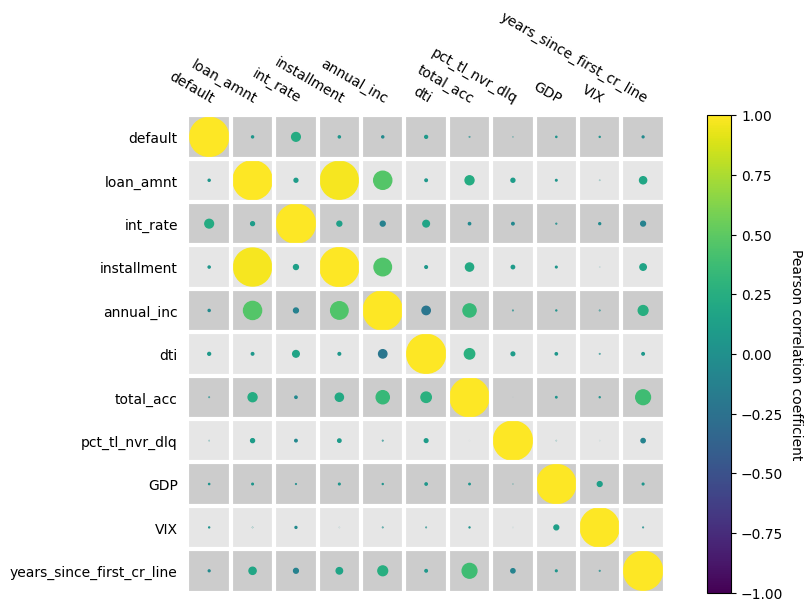

In [30]:
kwargs = {
    'heatmap': {
        'vmin': -1,
        'vmax': 1,
        'cmap': 'viridis',
    },
    'figure': {
        'figsize': (10, 6),
    },
}

plot_correlation_heatmap(train_set[numeric_columns], bubble=True, annotate=False, **kwargs)
plt.show()

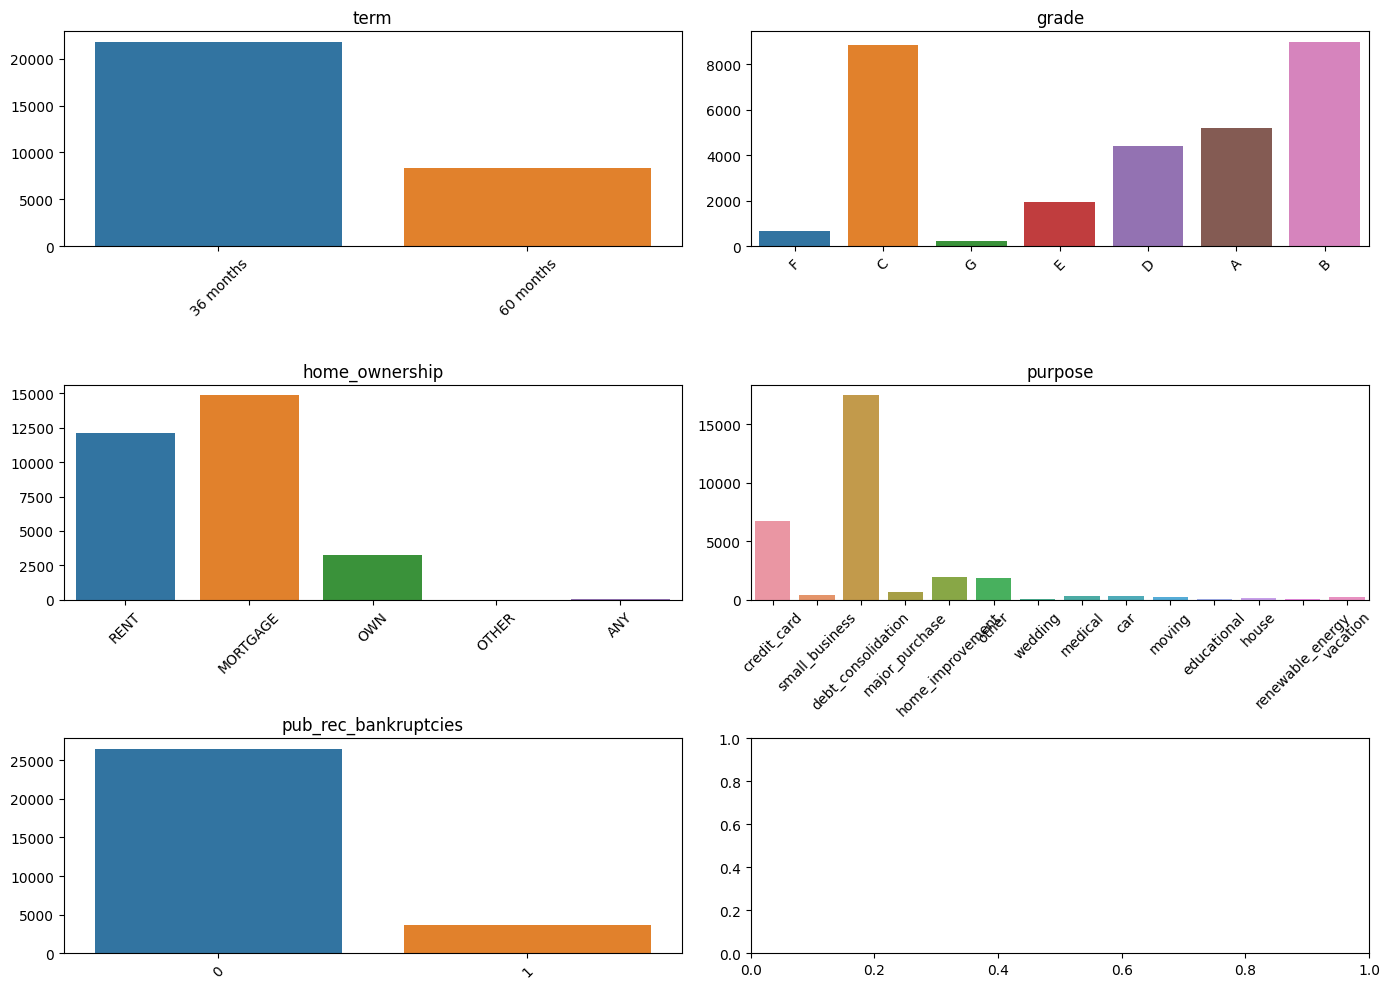

In [31]:
# boxplot of categorical features
categorical_columns = train_set.select_dtypes(include=['object']).columns

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=train_set, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [32]:
# missing data percentages 
missing_data = train_set.isnull().mean() * 100
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

missing_data

pct_tl_nvr_dlq    3.984248
dti               0.072802
annual_inc        0.029783
dtype: float64

# Optimal Binning on Categorical Variables

In [33]:
# let's see the effect of Binning Process on the categorical features
X_cat = train_set[categorical_columns]
y = train_set['default']


# define the binning process
binning_process = BinningProcess(variable_names=categorical_columns.tolist())

# fit the binning process
binning_process.fit(X_cat, y)

# transform the data
X_cat_binned = binning_process.transform(X_cat)

X_cat_binned

,term,grade,home_ownership,purpose,pub_rec_bankruptcies
issue_d,,,,,
2007-07-01,0.199365,-1.012277,-0.171090,0.147019,0.035131
2007-07-01,0.199365,-0.107363,-0.171090,-0.078755,0.035131
2007-10-01,0.199365,-1.012277,-0.171090,-0.078755,0.035131
2007-10-01,0.199365,-1.012277,-0.171090,-0.078755,0.035131
2007-11-01,0.199365,-1.012277,-0.171090,-0.078755,0.035131
...,...,...,...,...,...
2017-12-01,-0.426177,0.404931,0.152775,-0.078755,0.035131
2017-12-01,0.199365,1.205318,0.152775,0.147019,0.035131
2017-12-01,0.199365,1.205318,-0.171090,-0.078755,0.035131


In [34]:
binning_process.summary()

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,term,categorical,OPTIMAL,True,2,0.084369,0.010487,0.134873,0.183438
1,grade,categorical,OPTIMAL,True,5,0.378212,0.045388,0.327742,0.892498
2,home_ownership,categorical,OPTIMAL,True,3,0.023323,0.002912,0.079624,0.070558
3,purpose,categorical,OPTIMAL,True,4,0.012484,0.001559,0.054306,0.019228
4,pub_rec_bankruptcies,categorical,OPTIMAL,True,2,0.008131,0.001014,0.030483,0.009686


In [35]:
optb = binning_process.get_binned_variable("grade")
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[A],5179,0.171382,4878,301,0.058119,1.205318,0.164341,0.019383
1,[B],8991,0.297528,7905,1086,0.120787,0.404931,0.042536,0.005281
2,[C],8851,0.292895,7200,1651,0.186533,-0.107363,0.003496,0.000437
3,[D],4406,0.145802,3293,1113,0.252610,-0.495323,0.041726,0.005163
4,"[E, F, G]",2792,0.092392,1782,1010,0.361748,-1.012277,0.126113,0.015124
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,30219,1.000000,25058,5161,0.170787,,0.378212,0.045388


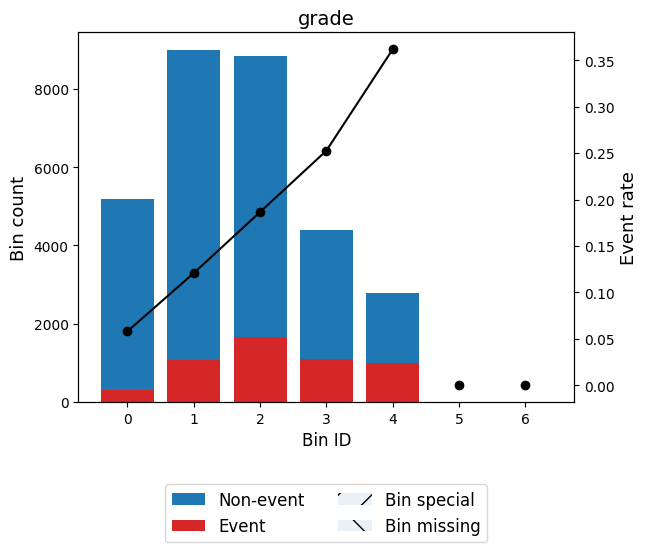

In [36]:
optb = binning_process.get_binned_variable("grade")
optb.binning_table.plot(metric="event_rate")

In [37]:
# optb = binning_process.get_binned_variable("purpose")
# optb.binning_table.plot(metric="event_rate")

Optimal Binning seems to work fine on categorical predictors. Therefore, we keep this method to encode categorical predictors in the pipeline.

In [38]:
X_train = train_set.drop('default', axis=1)
y_train = train_set['default']

X_test = test_set.drop('default', axis=1)
y_test = test_set['default']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(30219, 15)
(30219,)
(12056, 15)
(12056,)


# Cross-Validation Split

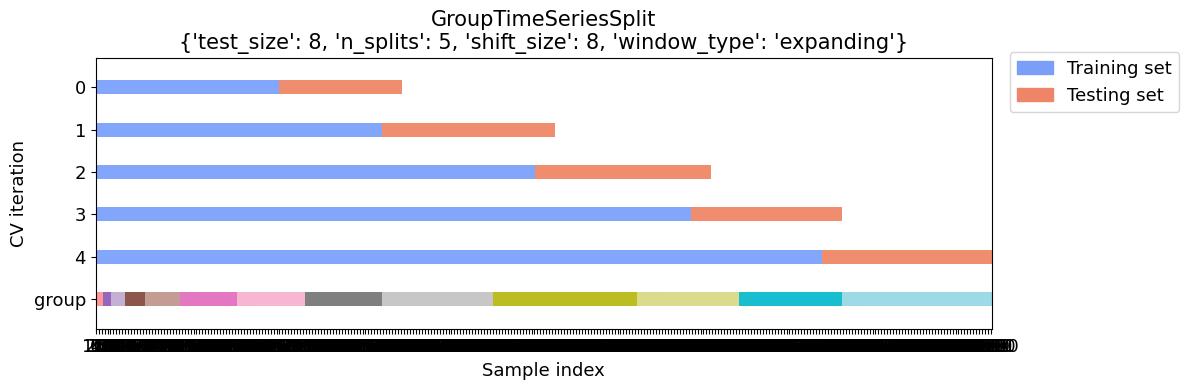

Train indices: [   0    1    2 ... 6511 6512 6513]
Test indices: [6514 6515 6516 ... 9986 9987 9988]
Train length: 6514
Test length: 3475
Train groups: ['2007-07-01T00:00:00.000000000' '2007-07-01T00:00:00.000000000'
 '2007-10-01T00:00:00.000000000' ... '2014-08-01T00:00:00.000000000'
 '2014-08-01T00:00:00.000000000' '2014-08-01T00:00:00.000000000']
Test groups: ['2014-09-01T00:00:00.000000000' '2014-09-01T00:00:00.000000000'
 '2014-09-01T00:00:00.000000000' ... '2015-04-01T00:00:00.000000000'
 '2015-04-01T00:00:00.000000000' '2015-04-01T00:00:00.000000000']
Train group size: 84
Test group size: 8
Train group months: ['2007-07-01T00:00:00.000000000' '2007-07-01T00:00:00.000000000'
 '2007-10-01T00:00:00.000000000' ... '2014-08-01T00:00:00.000000000'
 '2014-08-01T00:00:00.000000000' '2014-08-01T00:00:00.000000000']
Test group months: ['2014-09-01T00:00:00.000000000' '2014-09-01T00:00:00.000000000'
 '2014-09-01T00:00:00.000000000' ... '2015-04-01T00:00:00.000000000'
 '2015-04-01T00:00:00.

In [39]:
cv_args = {"test_size": 8, "n_splits": 5, "shift_size": 8, "window_type": "expanding"}

groups = X_train.index
plot_splits(X_train, y_train, groups, **cv_args)
print_split_info(X_train, y_train, groups, **cv_args)

In [40]:
cv = GroupTimeSeriesSplit(**cv_args)

# Preprocessing Steps

In [41]:
numeric_columns = X_train.select_dtypes(include=[np.number]).columns
numeric_columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'total_acc', 'pct_tl_nvr_dlq', 'GDP', 'VIX',
       'years_since_first_cr_line'],
      dtype='object')

In [42]:
categorical_columns = X_train.select_dtypes(include=['object']).columns
categorical_columns

Index(['term', 'grade', 'home_ownership', 'purpose', 'pub_rec_bankruptcies'], dtype='object')

In [43]:
# define the pipeline for numeric columns
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# define the pipeline for categorical columns
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', BinningProcess(variable_names=categorical_columns.tolist()))
])

# define the preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_columns),
    ('cat', categorical_pipeline, categorical_columns)
    ])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'total_acc', 'pct_tl_nvr_dlq', 'GDP', 'VIX',
       'years_since_first_cr_line'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  BinningProcess(variable_names=['term',
                                                                                 'grade',
                                                                                 'home_ownership',
                                                                                 'purpose',
                                                                                 'pub_rec_bankruptcies']))]),
                                 Index(['term', 'grade', 'home_ownership', 'purpose', 'pub_rec_bankruptcies'], dtype='object'))])

# Scoring Metrics

In [44]:
from sklearn.metrics import make_scorer

def specificity_score(y_true, y_pred):
    tn = sum((y_true == 0) & (y_pred == 0))
    fp = sum((y_true == 0) & (y_pred == 1))
    specificity = tn / (tn + fp)
    return specificity

specificity = make_scorer(specificity_score)

# gini score as 2 * AUC - 1
def gini_score(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1

gini = make_scorer(gini_score, needs_proba=True)

In [45]:
scoring = {'f1': 'f1', 'sensitivity': 'recall', 'specificity': specificity, 'gini': gini, 'auc': 'roc_auc'}

# Baseline Logistic Regression

In [46]:
lg_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression())
])

lg_cv_results = cross_validate(lg_pipe, X_train, y_train, groups=groups, cv=cv, scoring=scoring)
lg_cv_results = pd.DataFrame(lg_cv_results)
lg_cv_results.to_csv('../Results/Results_LogisticReg.csv', index=False)
lg_cv_results

,fit_time,score_time,test_f1,test_sensitivity,test_specificity,test_gini,test_auc
0,0.473257,0.134423,0.395760,0.624204,0.662452,0.388612,0.694306
1,0.767799,0.128757,0.408799,0.588121,0.680502,0.377461,0.688731
2,0.917579,0.137745,0.388560,0.594567,0.658142,0.348745,0.674373
3,0.910292,0.106289,0.334576,0.600297,0.642342,0.337598,0.668799
4,1.219280,0.120112,0.309392,0.502564,0.704491,0.297998,0.648999


In [47]:
# fit train data
lg_pipe.fit(X_train, y_train)

# predict test data
y_pred = lg_pipe.predict(X_test)

In [48]:
tn, fp, fn, tp  = confusion_matrix(y_test, y_pred).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Test Sensitivity: {sensitivity:.2f}')
print(f'Test Specificity: {specificity:.2f}')
print(f'Test F1 Score: {f1:.2f}')
print(f'Test Gini score: {2 * roc_auc - 1:.2f}')
print(f'Test AUC: {roc_auc:.2f}')

Test Sensitivity: 0.63
Test Specificity: 0.64
Test F1 Score: 0.22
Test Gini score: 0.27
Test AUC: 0.64


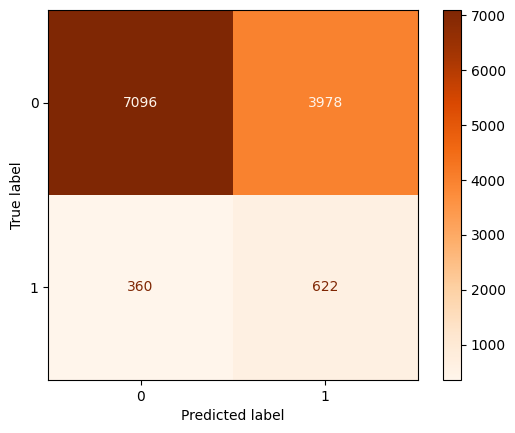

In [49]:
# Display confusion matrix

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()

In [50]:
# save the model
joblib.dump(lg_pipe, '../Models/LogisticRegression.pkl')

['../Models/LogisticRegression.pkl']

# Random Forest

In [51]:
rf_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Hyper-parameter Tuning

In [52]:
grid = {'classifier__max_depth': [8, 15, None], 
        'classifier__max_features': ['sqrt', 0.5, None],
        'classifier__n_estimators': [50, 100, 200]
        }

gs = GridSearchCV(rf_pipe, 
                  grid, 
                  cv=cv, 
                  scoring=scoring, 
                  refit='f1', 
                  n_jobs=-1)

gs.fit(X_train, y_train, groups=groups)

results = pd.DataFrame(gs.cv_results_)

In [53]:
results = results.sort_values(by='rank_test_f1')
results.to_csv('../Results/Results_RandomForest.csv', index=False)
print(gs.best_params_)
print(gs.best_score_)

{'classifier__max_depth': 8, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 200}
0.2900125531449394


In [54]:
best_model = gs.best_estimator_

# predict test data
rf_y_pred = best_model.predict(X_test)

tn, fp, fn, tp  = confusion_matrix(y_test, rf_y_pred).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = f1_score(y_test, rf_y_pred)
roc_auc = roc_auc_score(y_test, rf_y_pred)

print(f'Test Sensitivity: {sensitivity:.2f}')
print(f'Test Specificity: {specificity:.2f}')
print(f'Test F1 Score: {f1:.2f}')
print(f'Test Gini score: {2 * roc_auc - 1:.2f}')
print(f'Test AUC: {roc_auc:.2f}')

Test Sensitivity: 0.41
Test Specificity: 0.80
Test F1 Score: 0.23
Test Gini score: 0.21
Test AUC: 0.61


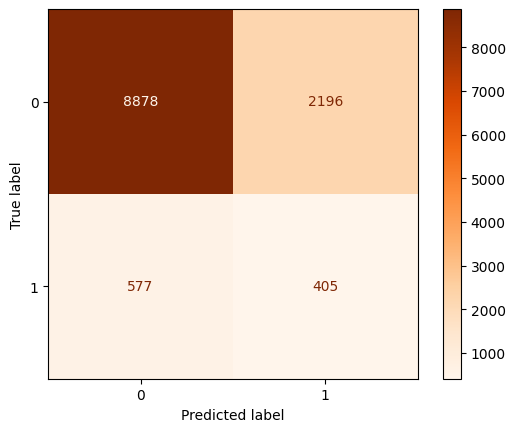

In [55]:
# Display confusion matrix

cm = confusion_matrix(y_test, rf_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()

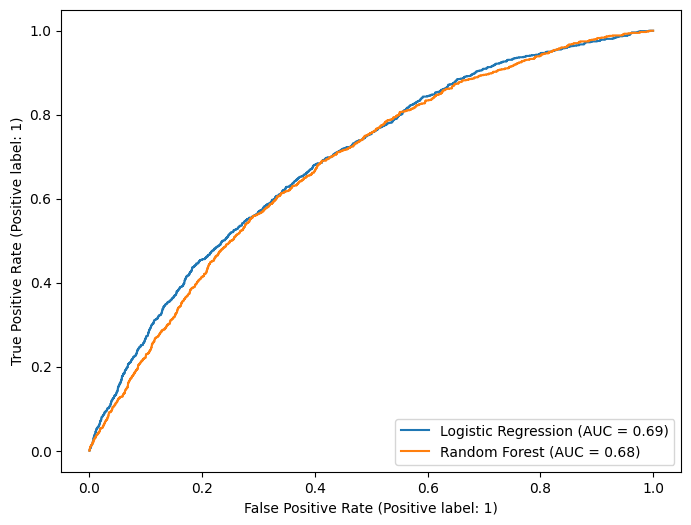

In [56]:
# plot roc curve for logistic regression and random forest
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# logistic regression
disp = RocCurveDisplay.from_estimator(lg_pipe, X_test, y_test, ax=ax, name='Logistic Regression')

# random forest
disp = RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax, name='Random Forest')

plt.show() 

In [57]:
# save the model
joblib.dump(best_model, '../Models/RandomForest.pkl')

['../Models/RandomForest.pkl']

In [58]:
# end timing
end = time.time()

print(f'Time taken: {end - start:.2f} seconds')

Time taken: 1384.18 seconds


In [59]:
# print session info
session_info.show()